# Description

It selects a set of specific gene pairs from a tissue, and checks if relationship are replicated on other tissues.
It also uses GTEx metadata (such as sex) to explain relationships.

# Modules

In [1]:
import pandas as pd

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from ccc import conf
from ccc.coef import ccc

# Settings

In [2]:
# this gene pair was originally found with ccc on whole blood
# interesting: https://clincancerres.aacrjournals.org/content/26/21/5567.figures-only
gene0_id, gene1_id = "ENSG00000147050.14", "ENSG00000183878.15"
gene0_symbol, gene1_symbol = "KDM6A", "UTY"

# Paths

In [3]:
TISSUE_DIR = conf.GTEX["DATA_DIR"] / "data_by_tissue"
assert TISSUE_DIR.exists()

In [4]:
OUTPUT_FIGURE_DIR = (
    conf.MANUSCRIPT["FIGURES_DIR"]
    / "coefs_comp"
    / f"{gene0_symbol.lower()}_vs_{gene1_symbol.lower()}"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty')

# Data

## GTEx metadata

In [5]:
gtex_metadata = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_v8-sample_metadata.pkl")

In [6]:
gtex_metadata.shape

(22951, 66)

In [7]:
gtex_metadata.head()

,SUBJID,SEX,AGE,DTHHRDY,SMATSSCR,SMCENTER,SMPTHNTS,SMRIN,SMTS,SMTSD,...,SME1ANTI,SMSPLTRD,SMBSMMRT,SME1SNSE,SME1PCTS,SMRRNART,SME1MPRT,SMNUM5CD,SMDPMPRT,SME2PCTS
SAMPID,,,,,,,,,,,,,,,,,,,,,
GTEX-1117F-0003-SM-58Q7G,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-5DWSB,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0003-SM-6WBT7,GTEX-1117F,Female,60-69,4.0,NaN,B1,NaN,NaN,Blood,Whole Blood,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10a-SM-AHZ7F,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,NaN,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTEX-1117F-0011-R10b-SM-CYKQ8,GTEX-1117F,Female,60-69,4.0,NaN,"B1, A1",NaN,7.2,Brain,Brain - Frontal Cortex (BA9),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Gene Ensembl ID -> Symbol mapping

In [8]:
gene_map = pd.read_pickle(conf.GTEX["DATA_DIR"] / "gtex_gene_id_symbol_mappings.pkl")

In [9]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [10]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

In [11]:
assert gene_map[gene0_id] == gene0_symbol
assert gene_map[gene1_id] == gene1_symbol

# Compute correlation on all tissues

In [12]:
res_all = pd.DataFrame(
    {
        f.stem.split("_data_")[1]: {
            "cm": ccc(data[gene0_id], data[gene1_id]),
            "pearson": pearsonr(data[gene0_id], data[gene1_id])[0],
            "spearman": spearmanr(data[gene0_id], data[gene1_id])[0],
        }
        for f in TISSUE_DIR.glob("*.pkl")
        if (data := pd.read_pickle(f).T[[gene0_id, gene1_id]].dropna()) is not None
        and data.shape[0] > 10
    }
).T.abs()

In [13]:
res_all.shape

(27, 3)

In [14]:
res_all.head()

,cm,pearson,spearman
heart_left_ventricle,0.334440,0.183529,0.006030
heart_atrial_appendage,0.246321,0.095973,0.039109
vagina,0.013525,0.074307,0.086761
adipose_visceral_omentum,0.280211,0.198846,0.053794
brain_nucleus_accumbens_basal_ganglia,0.291776,0.249914,0.256930


In [15]:
res_all.sort_values("cm")

,cm,pearson,spearman
uterus,0.000000,0.016338,0.041994
ovary,0.006722,0.104096,0.013011
vagina,0.013525,0.074307,0.086761
brain_cerebellum,0.187717,0.124874,0.036402
small_intestine_terminal_ileum,0.193668,0.359150,0.327394
brain_spinal_cord_cervical_c1,0.198741,0.243850,0.125183
testis,0.206704,0.692661,0.690990
brain_cortex,0.219900,0.162729,0.144386
brain_anterior_cingulate_cortex_ba24,0.231620,0.002993,0.182207
brain_cerebellar_hemisphere,0.237310,0.147620,0.259815


In [16]:
res_all.sort_values("pearson")

,cm,pearson,spearman
brain_anterior_cingulate_cortex_ba24,0.231620,0.002993,0.182207
uterus,0.000000,0.016338,0.041994
brain_amygdala,0.280524,0.037541,0.147571
brain_frontal_cortex_ba9,0.265633,0.051099,0.188904
bladder,0.330097,0.061798,0.022107
vagina,0.013525,0.074307,0.086761
heart_atrial_appendage,0.246321,0.095973,0.039109
ovary,0.006722,0.104096,0.013011
brain_caudate_basal_ganglia,0.287850,0.118342,0.199696
brain_cerebellum,0.187717,0.124874,0.036402


In [17]:
res_all.sort_values("spearman")

,cm,pearson,spearman
heart_left_ventricle,0.334440,0.183529,0.006030
ovary,0.006722,0.104096,0.013011
bladder,0.330097,0.061798,0.022107
brain_cerebellum,0.187717,0.124874,0.036402
heart_atrial_appendage,0.246321,0.095973,0.039109
uterus,0.000000,0.016338,0.041994
adipose_visceral_omentum,0.280211,0.198846,0.053794
vagina,0.013525,0.074307,0.086761
whole_blood,0.294391,0.239870,0.100621
brain_spinal_cord_cervical_c1,0.198741,0.243850,0.125183


# Plot

In [18]:
def get_tissue_file(name):
    """
    Given a part of a tissue name, it returns a file path to the
    expression data for that tissue in GTEx. It fails if more than
    one files are found.

    Args:
        name: a string with the tissue name (or a part of it).

    Returns:
        A Path object pointing to the gene expression file for the
        given tissue.
    """
    tissue_files = []
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            tissue_files.append(f)

    assert len(tissue_files) == 1
    return tissue_files[0]

In [19]:
# testing
_tmp = get_tissue_file("whole_blood")
assert _tmp.exists()

In [20]:
def simplify_tissue_name(tissue_name):
    return f"{tissue_name[0].upper()}{tissue_name[1:].replace('_', ' ')}"

In [21]:
assert simplify_tissue_name("whole_blood") == "Whole blood"
assert simplify_tissue_name("uterus") == "Uterus"

In [22]:
def plot_gene_pair(
    tissue_name, gene0, gene1, hue=None, kind="hex", ylim=None, bins="log"
):
    """
    It plots (joint plot) a gene pair from the given tissue. It saves the plot
    for the manuscript.
    """
    # merge gene expression with metadata
    tissue_file = get_tissue_file(tissue_name)
    tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]
    tissue_data = pd.merge(
        tissue_data,
        gtex_metadata,
        how="inner",
        left_index=True,
        right_index=True,
        validate="one_to_one",
    )

    # get gene symbols
    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # compute correlations for this gene pair
    _clustermatch = ccc(tissue_data[gene0], tissue_data[gene1])
    _pearson = pearsonr(tissue_data[gene0], tissue_data[gene1])[0]
    _spearman = spearmanr(tissue_data[gene0], tissue_data[gene1])[0]

    _title = f"{simplify_tissue_name(tissue_name)}\n$c={_clustermatch:.2f}$  $p={_pearson:.2f}$  $s={_spearman:.2f}$"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
        "rasterized": True,
    }
    if hue is None:
        other_args["bins"] = bins
    else:
        other_args["hue_order"] = ["Male", "Female"]

    with sns.plotting_context("paper", font_scale=1.5):
        p = sns.jointplot(
            data=tissue_data,
            x=gene0,
            y=gene1,
            hue=hue,
            **other_args,
            # ylim=(0, 500),
        )

        if ylim is not None:
            p.ax_joint.set_ylim(ylim)

        gene_x_id = p.ax_joint.get_xlabel()
        gene_x_symbol = gene_map[gene_x_id]
        p.ax_joint.set_xlabel(f"{gene_x_symbol}", fontstyle="italic")

        gene_y_id = p.ax_joint.get_ylabel()
        gene_y_symbol = gene_map[gene_y_id]
        p.ax_joint.set_ylabel(f"{gene_y_symbol}", fontstyle="italic")

        p.fig.suptitle(_title)

        # save
        output_file = (
            OUTPUT_FIGURE_DIR
            / f"gtex_{tissue_name}-{gene_x_symbol}_vs_{gene_y_symbol}.svg"
        )
        display(output_file)

        plt.savefig(
            output_file,
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
        )

    return tissue_data

## In whole blood (where this gene pair was found)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_whole_blood-KDM6A_vs_UTY.svg')

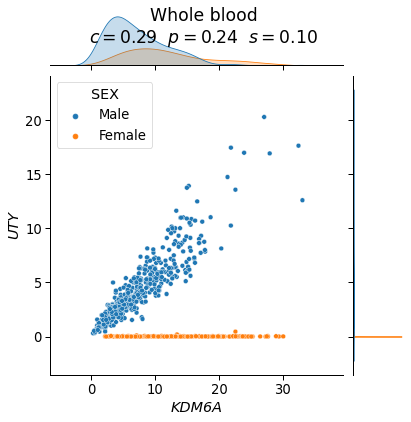

In [23]:
_tissue_data = plot_gene_pair(
    "whole_blood",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Lowest tissues in ccc

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_uterus-KDM6A_vs_UTY.svg')

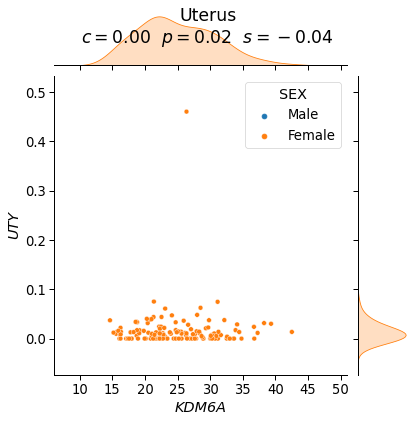

In [24]:
_tissue_data = plot_gene_pair(
    "uterus",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_ovary-KDM6A_vs_UTY.svg')

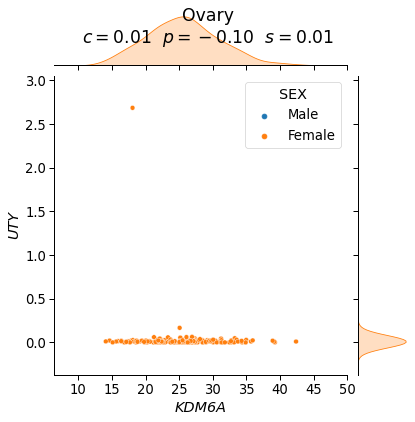

In [25]:
_tissue_data = plot_gene_pair(
    "ovary",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_vagina-KDM6A_vs_UTY.svg')

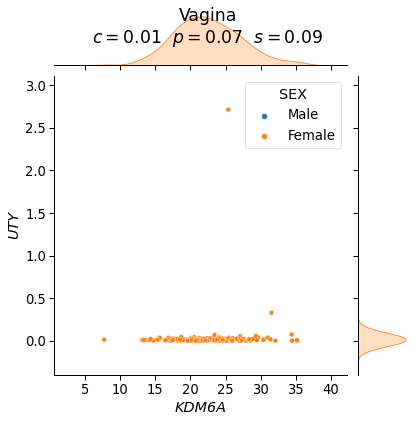

In [26]:
_tissue_data = plot_gene_pair(
    "vagina",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_brain_cerebellum-KDM6A_vs_UTY.svg')

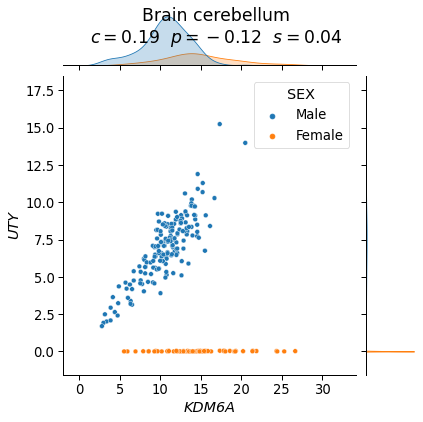

In [27]:
_tissue_data = plot_gene_pair(
    "brain_cerebellum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_small_intestine_terminal_ileum-KDM6A_vs_UTY.svg')

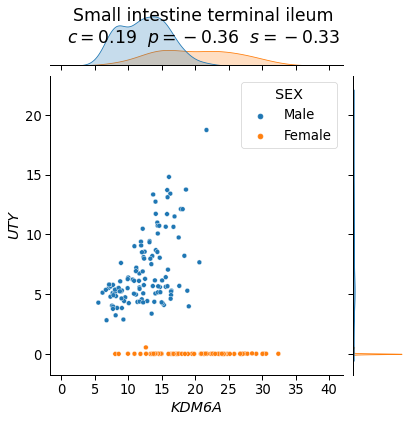

In [28]:
_tissue_data = plot_gene_pair(
    "small_intestine_terminal_ileum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_brain_spinal_cord_cervical_c1-KDM6A_vs_UTY.svg')

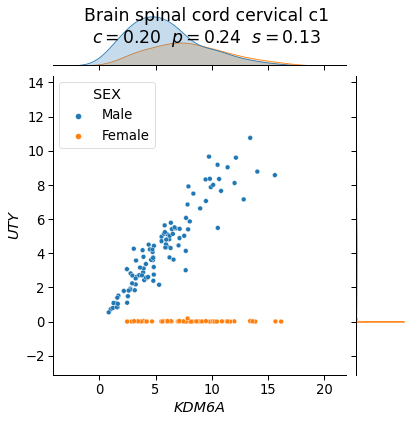

In [29]:
_tissue_data = plot_gene_pair(
    "brain_spinal_cord_cervical_c1",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_testis-KDM6A_vs_UTY.svg')

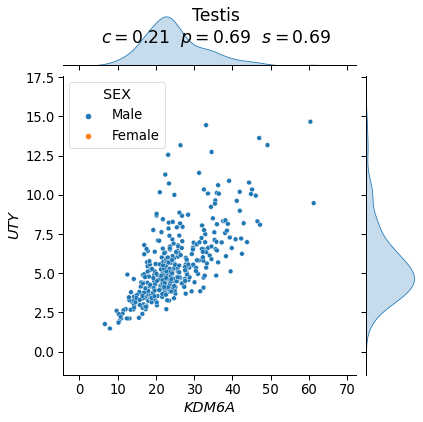

In [30]:
_tissue_data = plot_gene_pair(
    "testis",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Highest tissues in ccc

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_cells_cultured_fibroblasts-KDM6A_vs_UTY.svg')

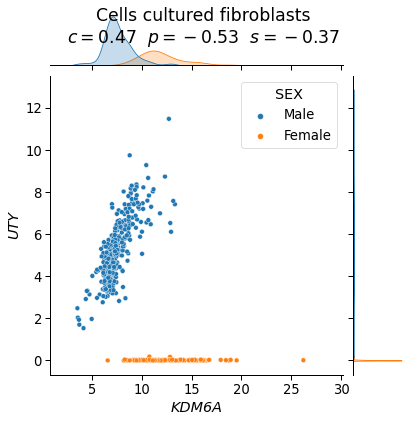

In [31]:
_tissue_data = plot_gene_pair(
    "cells_cultured_fibroblasts",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_breast_mammary_tissue-KDM6A_vs_UTY.svg')

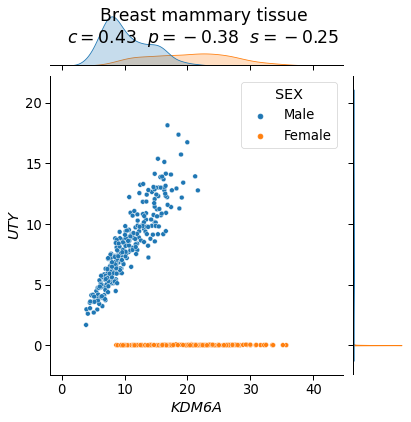

In [32]:
_tissue_data = plot_gene_pair(
    "breast_mammary_tissue",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Pearson low, CCC high

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_brain_anterior_cingulate_cortex_ba24-KDM6A_vs_UTY.svg')

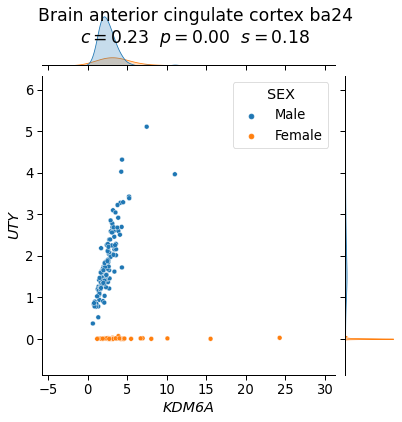

In [33]:
_tissue_data = plot_gene_pair(
    "brain_anterior_cingulate_cortex_ba24",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_brain_amygdala-KDM6A_vs_UTY.svg')

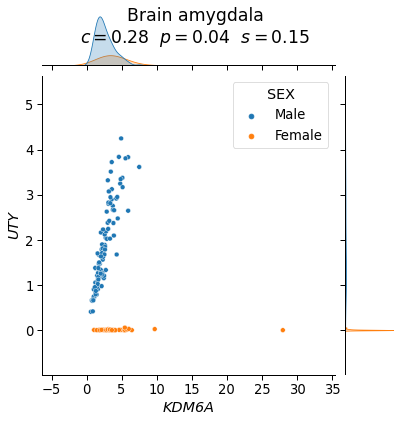

In [34]:
_tissue_data = plot_gene_pair(
    "brain_amygdala",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_brain_frontal_cortex_ba9-KDM6A_vs_UTY.svg')

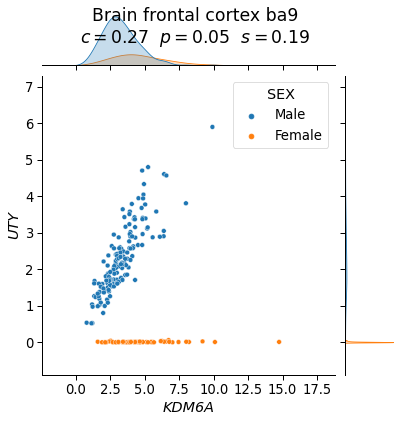

In [35]:
_tissue_data = plot_gene_pair(
    "brain_frontal_cortex_ba9",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_bladder-KDM6A_vs_UTY.svg')

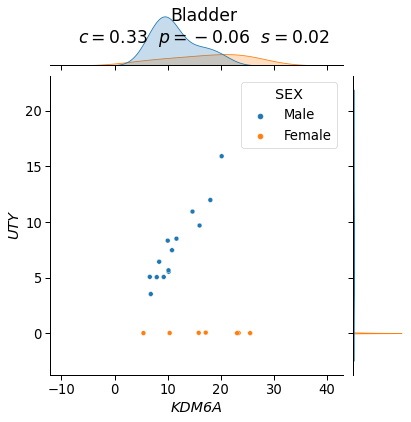

In [36]:
_tissue_data = plot_gene_pair(
    "bladder",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_heart_atrial_appendage-KDM6A_vs_UTY.svg')

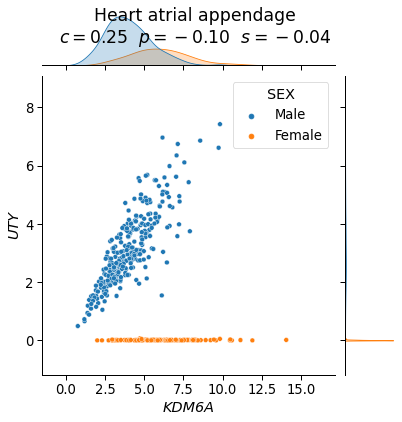

In [37]:
_tissue_data = plot_gene_pair(
    "heart_atrial_appendage",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

## Spearman low, CCC high

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_heart_left_ventricle-KDM6A_vs_UTY.svg')

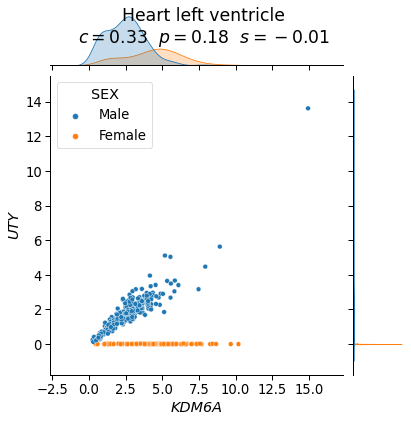

In [38]:
_tissue_data = plot_gene_pair(
    "heart_left_ventricle",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_adipose_visceral_omentum-KDM6A_vs_UTY.svg')

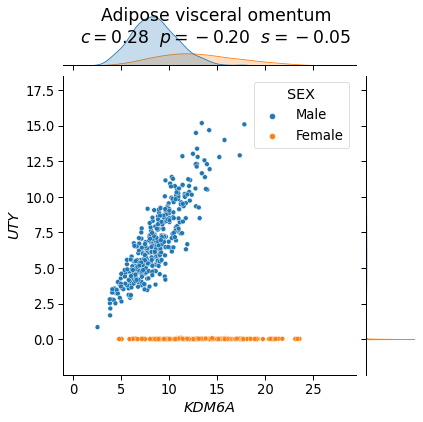

In [39]:
_tissue_data = plot_gene_pair(
    "adipose_visceral_omentum",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_skin_not_sun_exposed_suprapubic-KDM6A_vs_UTY.svg')

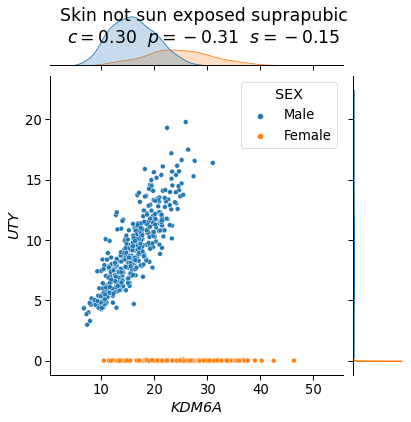

In [40]:
_tissue_data = plot_gene_pair(
    "skin_not_sun_exposed_suprapubic",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

('KDM6A', 'UTY')

PosixPath('/opt/manuscript/content/images/coefs_comp/kdm6a_vs_uty/gtex_pancreas-KDM6A_vs_UTY.svg')

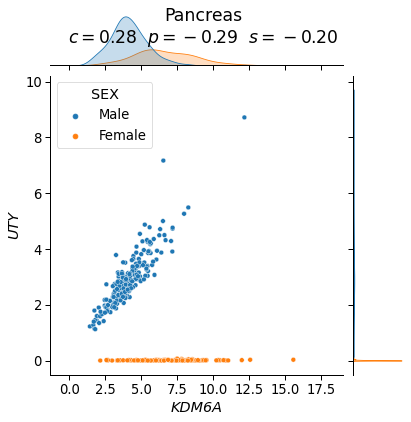

In [41]:
_tissue_data = plot_gene_pair(
    "pancreas",
    gene0_id,
    gene1_id,
    hue="SEX",
    kind="scatter",
)

# Create final figure

In [43]:
from svgutils.compose import Figure, SVG, Panel

In [48]:
Figure(
    "607.67480cm",
    "870.45984cm",
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex_whole_blood-KDM6A_vs_UTY.svg").scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_testis-KDM6A_vs_UTY.svg").scale(0.5).move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_cells_cultured_fibroblasts-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex_brain_cerebellum-KDM6A_vs_UTY.svg").scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_small_intestine_terminal_ileum-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_breast_mammary_tissue-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ).move(0, 220),
    Panel(
        SVG(
            OUTPUT_FIGURE_DIR
            / "gtex_brain_anterior_cingulate_cortex_ba24-KDM6A_vs_UTY.svg"
        ).scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_brain_amygdala-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_heart_atrial_appendage-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ).move(0, 220 * 2),
    Panel(
        SVG(OUTPUT_FIGURE_DIR / "gtex_vagina-KDM6A_vs_UTY.svg").scale(0.5),
        SVG(OUTPUT_FIGURE_DIR / "gtex_ovary-KDM6A_vs_UTY.svg").scale(0.5).move(200, 0),
        SVG(OUTPUT_FIGURE_DIR / "gtex_uterus-KDM6A_vs_UTY.svg")
        .scale(0.5)
        .move(200 * 2, 0),
    ).move(0, 220 * 3),
).save(OUTPUT_FIGURE_DIR / "gtex-KDM6A_vs_UTY-main.svg")

Now open the file, reside to fit drawing to page, and add a white rectangle to the background.